# Dating Preferences
**ECE 225A: Probability and Statistics for Data Science
<br/>
Yuxin Wang (A59019958) and Merve Kilic (A15978640)**

## Introduction

Dating is a popular topic in many people’s lives. It’s a long, emotional process for many, filled with vast amounts of trial and error. Although individuals and their dating preferences differ, we hope to find some generalizations through the analysis of speed dating data in order to add some clarity to the complicated process of dating.


## Dataset

The speed dating dataset, collected by  Columbia Business School, was downloaded from Kaggle [1]. The data was gathered through 21 speed dating experiments of 551 participants during 2002-2004. The dataset has 8,378 rows representing the information of each pair of participant and partner, and 195 columns which was collected from three phases: setup, first follow-up (2), and second follow-up (3). Before the experiment, participants were asked to take a survey, including basic information like age, race, gender, self-evaluation, and dating preferences. During each experiment, each participant spent four minutes speed dating  participants of the opposite gender. After the experiments, participants filled out a feedback and after-thought survey. After 3-4 weeks, participants were requested to fill out a third and final survey with updates on their matches.

## Preprocessing
Besides preprocessing the null values and outliers, after considering the participation of candidates in the follow-up surveys, we added two new features into our dataset: sur2 and sur3, representing the participation of phase two and three.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
df = pd.read_csv('SpeedDatingData.csv',encoding='ISO-8859-1')
pd.options.mode.chained_assignment = None  # default='warn'
#https://www.kaggle.com/datasets/annavictoria/speed-dating-experiment

In [2]:
# STEP1:drop some columns
df.drop(['round','condtn','idg','position','positin1','undergra','mn_sat','tuition','zipcode','income','field','expnum','career'],axis = 1,inplace=True)

In [3]:
#STEP2:processing id & pid
df['id'].fillna(22,inplace = True)
df.id = df.id.astype('int64')

df.loc[df.pid.isna(),'pid'] = 128
df.pid = df.pid.astype('int64')

In [4]:
#STEP3:processing age & age_O
wav = df.wave.unique()
result = df.groupby(by = 'wave').get_group(wav[0])
m = result.age.mean()
result['age'].fillna(float(int(m)),inplace=True) 
for item in wav[1:]:
    temp = df.groupby(by = 'wave').get_group(item)
    temp['age'].fillna(int(temp.age.mean()),inplace=True) 
    result = pd.concat([result,temp],ignore_index=True,axis=0)

result['age_o'] = result.apply(lambda x: result.loc[result.iid.__eq__(x.pid)].age.iloc[0],axis=1)
df = result.copy()

df.age = df.age.astype('int64')
df.age_o = df.age_o.astype('int64')

In [5]:
#STEP3:processing race & race_O
df.loc[df.iid.__eq__(58),'race'] = 4
df.loc[df.iid.__eq__(59),'race'] = 4
df.loc[df.iid.__eq__(136),'race'] = 6
df.loc[df.iid.__eq__(339),'race'] = 6
df.loc[df.iid.__eq__(340),'race'] = 6
df.loc[df.iid.__eq__(346),'race'] = 1
df['race_o'] = df.apply(lambda x: df.loc[df.iid.__eq__(x.pid)].race.iloc[0],axis=1)
df.race = df.race.astype('int64')
df.race_o = df.race_o.astype('int64')

In [6]:
#STEP4:processing pf_o & attr1_1: 6-9 range(1-10) 1-5 10-21:1-100(total points == 100)
# after check the data, attr1_1 6-9 have been rescaled 
col = df.columns[df.columns.str.contains('1_1')]
for item in col:
    df[item].fillna(df[item].mean(),inplace=True)
#normalization
df[col] = np.array(df[col])/np.array(df[col].sum(axis = 1)).T[:,None] *100

dct = dict(zip(df.columns[df.columns.str.contains('pf_o')],df.columns[df.columns.str.contains('1_1')]))
col = df.columns[df.columns.str.contains('pf_o')]
for item in col:
    df[item] = df.apply(lambda x: df.loc[df.iid.__eq__(x.pid),dct[item]].iloc[0],axis=1)

In [7]:
#STEP5:processing attr_o:attr_o is a rating by partner, which is unrelated with other attr
# using mean value to fill 
# range(1-10)
dtc = df.columns[df.columns.str.contains('1_1')].str.replace('1_1','')
dtc = list(dtc)+['like','prob','met']
col = [item+'_o' for item in dtc]
for item in col:
    df[item].fillna(df[item].mean(),inplace=True)

In [8]:
#STEP6: processing field_cd
df['field_cd'].fillna(18,inplace = True)
df.field_cd = df.field_cd.astype('int64')

In [9]:
#STEP7:processing imprace imprelig: subject rate
# range(1-10)
col = ['imprace','imprelig']
for item in col:
    df[item].fillna(df[item].mean(),inplace=True)

In [10]:
#STEP8:processing interest:using mean to represent
#range(1-10) 
col = 'sports	tvsports	exercise	dining	museums	art	hiking	gaming	clubbing'.split('\t')
col +=['reading']
col +='tv	theater	movies	concerts	music	shopping	yoga'.split('\t')
for item in col:
    df[item].fillna(df[item].mean(),inplace=True)

In [11]:
#STEP9:processing from goal date go_out: using mode
col = 'from	goal	date	go_out'.split('\t')
for item in col:
    df[item].fillna(df[item].mode()[0],inplace=True)

for item in col[1:]:
    df[item] = df[item].astype('int64')

In [12]:
#STEP10:processing career_cd
df.loc[df.iid.__eq__(1)|df.iid.__eq__(2),'career_c'] = 1
df.loc[df.iid.__eq__(3),'career_c'] = 7
df.loc[df.iid.__eq__(40),'career_c'] = 5
df['career_c'].fillna(15,inplace=True)
df.career_c = df.career_c.astype('int64')

In [13]:
#STEP11:processing exhappy
#range(1-10)
df['exphappy'].fillna(df['exphappy'].mean(),inplace=True)

In [14]:
#STEP12:processing attr_4_1       null rate 21%
# wave 1-5 not asked to answer this question 
# 6-9:range(1-10)
# 10-21:range(1-100)
# step 1: rescale 6-9
col = df.columns[df.columns.str.contains('4_1')]
df.loc[df.wave.isin(range(6,10)),col] = np.array(df.loc[df.wave.isin(range(6,10)),col])/np.array(df.loc[df.wave.isin(range(6,10)),col].sum(axis = 1)).T[:,None] *100
# step 2: finall using mean()
for c in col:
    df.loc[df.wave.isin(range(6,22)),c]= df.loc[df.wave.isin(range(6,22)),c].fillna(df[c].mean())
#normlization
df[col] = np.array(df[col])/np.array(df[col].sum(axis = 1)).T[:,None] *100
# step 3: NOTE: GROUP 1-5 not collected information of 4-1

In [15]:
#STEP13:processing attr2_1: opposite sex looks for in a date
# wave 6-9:1-10
# wave 1-5,10-21: total 100 points 
# step 1: rescale 6-9
col = df.columns[df.columns.str.contains('2_1')]
df.loc[df.wave.isin(range(6,10)),col] = np.array(df.loc[df.wave.isin(range(6,10)),col])/np.array(df.loc[df.wave.isin(range(6,10)),col].sum(axis = 1)).T[:,None] *100
# step 2: fillna using mean()
for c in col:
    df[c].fillna(df[c].mean(),inplace = True)
#normlization
df[col] = np.array(df[col])/np.array(df[col].sum(axis = 1)).T[:,None] *100

In [16]:
#STEP14: processing 3_1: you measure up yourself
#range 1-10
col = df.columns[df.columns.str.contains('3_1')]
for c in col:
    df[c].fillna(df[c].mean(),inplace=True)
#normlization
df[col] = np.array(df[col])/np.array(df[col].sum(axis = 1)).T[:,None] *100

In [17]:
#STEP14: processing 5_1: others perceive of you 
# lost over 50%, drop this value 
col = df.columns[df.columns.str.contains('5_1')]
df.drop(col,axis = 1,inplace=True)

In [18]:
#STEP15: processing match_es how matches exepcted to get 
# missing rate is around 13%
# using mode to fill
df['match_es'].fillna(df.match_es.mode()[0],inplace=True)
df.match_es = df.match_es.astype('int64')

In [19]:
#STEP16: rate the person met tonight  met/ like attr
# range(1-10), it's 
# subject evaluation, it's a little bit hard to predict 
# n/a means not sure, fillna with the 5 
col = ['attr','sinc', 'intel', 'fun', 'amb', 'shar', 'like', 'prob', 'met']
for c in col[:-1]:
    df[c].fillna(5,inplace=True)
    df[c] = df[c].astype('int')

df['met'].fillna(2,inplace=True)
df['met'] = df['met'].astype('int')

In [20]:
#STEP17:processing _s: represent the importance in potential date importance; same like 1_1
# lost rate: 50%
# drop these columns 
col = df.columns[df.columns.str.contains('_s')]
df.drop(col,axis=1,inplace=True)

In [21]:
#STEP 18: survey_2, many people may not take survey two
# many people fill the survey selectively
# step 1: create a new label 1: people partcipate the survey two 0: not 
namelist = ['7_2','1_2','4_2','2_2','3_2','5_2']
col_sr2= ['satis_2','length','numdat_2'] 
for n in namelist:
    col_sr2+=list(df.columns[df.columns.str.contains(n)])
df['sur2'] = 1
df.loc[df[col_sr2].isna().sum(axis=1)==len(col_sr2),'sur2']=0
df['sur2']  = df['sur2'].astype('int64')
 
# step 2: processing 'satis_2','length','numdat_2'
'''
for c in col_sr2[:3]:
    print(df.loc[df.sur2==1 & df[c].isna()].iid.unique())
>>>[] [] [2 11 14]
'''
df['numdat_2'].fillna(df.numdat_2.mode()[0],inplace=True)
df['numdat_2'] = df['numdat_2'].astype('int64')

In [22]:
#step3: handling 7_2:the actual importance of these attributes in your decisions. 
#range: sum to 100
'''
for n in namelist:
    col = df.columns[df.columns.str.contains(n)]
    print(n,df.loc[df[col].isna().sum(axis=1).isin(range(0,len(col)))].iid.unique().size) 
>>>7_2 126
>>>1_2 485
>>>4_2 368
>>>2_2 368
>>>3_2 485
>>>5_2 277
'''
df.drop(df.columns[df.columns.str.contains('7_2|5_2')],inplace=True,axis=1)
for n in (namelist[1:5]):
    col = df.columns[df.columns.str.contains(n)]
    for c in col:
        df.loc[df.sur2==1,c] = df.loc[df.sur2==1,c].fillna(df.loc[df.sur2==1,c].mean())
    #normlization
    df.loc[df.sur2==1,col] = np.array(df.loc[df.sur2==1,col])/np.array(df.loc[df.sur2==1,col].sum(axis = 1)).T[:,None] *100 

In [23]:
#STEP 18: survey_3, many people may not take survey Three
namelist = ['7_3','1_3','4_3','2_3','3_3','5_3']
col_sr2= ['you_call','them_cal','date_3','numdat_3','num_in_3'] 
for n in namelist:
    col_sr2+=list(df.columns[df.columns.str.contains(n)])
df['sur3'] = 1
df.loc[df[col_sr2].isna().sum(axis=1)==len(col_sr2),'sur3']=0
df['sur3'] = df['sur3'].astype('int64')

In [24]:
'''
for c in col_sr2[:5]:
    print(df.loc[df.sur3==1 & df[c].isna()].iid.unique().size)
>>> 0
>>> 0
>>> 0 
>>> 170
>>> 223
'''
df.drop(['numdat_3','num_in_3'],axis=1,inplace=True)

In [25]:
'''
for n in namelist:
    col = df.columns[df.columns.str.contains(n)]
    print(n,df.loc[df[col].isna().sum(axis=1).isin(range(0,len(col)))].iid.unique().size,df.loc[df.sur3==1].iid.unique().size) 
>>>7_3 131 263
>>>1_3 263 263
>>>4_3 193 263
>>>2_3 193 263
>>>3_3 263 263
>>>5_3 131 263
'''
df.drop(df.columns[df.columns.str.contains('7_3|5_3')],inplace=True,axis=1)
for n in (namelist[1:5]):
    col = df.columns[df.columns.str.contains(n)]
    for c in col:
        df.loc[df.sur3==1,c] = df.loc[df.sur3==1,c].fillna(df.loc[df.sur3==1,c].mean()) 
    #normlization
    df.loc[df.sur3==1,col] = np.array(df.loc[df.sur3==1,col])/np.array(df.loc[df.sur3==1,col].sum(axis = 1)).T[:,None] *100 

In [26]:
col = 'sports	tvsports	exercise	dining	museums	art	hiking	gaming	clubbing'.split('\t')
col +=['reading']
col +='tv	theater	movies	concerts	music	shopping	yoga'.split('\t')

In [27]:
#STEP19:int_corr
df['int_corr'] = df.apply(lambda x:x[col].astype('float64').corr(df.loc[df.iid == x.pid][col].iloc[0,:].astype('float64')),axis = 1)

In [28]:
df.to_csv('speedDatingProcessing.csv',index=False)

## Data Analysis and Visualization 

In order to guide our data analysis, we chose some questions (listed below) based off the write-up associated with our Kaggle dataset [1]. We will answer them using statistical methods and visualization tools in order to better understand speed dating.

1. What are the most and least desirable attributes in a male partner vs. in a female partner?
2. Is it better to be someone's first speed date of the night or their last?
3. How important do people think attractiveness is in potential mate selection vs. its real impact?
4. Is being the same race important? Is dating success rate related to race?

### Question 1: What are the most and least desirable attributes in a male partner vs. in a female partner?

In [29]:
df_m = df[df.gender == 1]
df_f = df[df.gender == 0]

     Figure 1: Boxplot of Female Attributes Ranked by Males, Separated by Decision


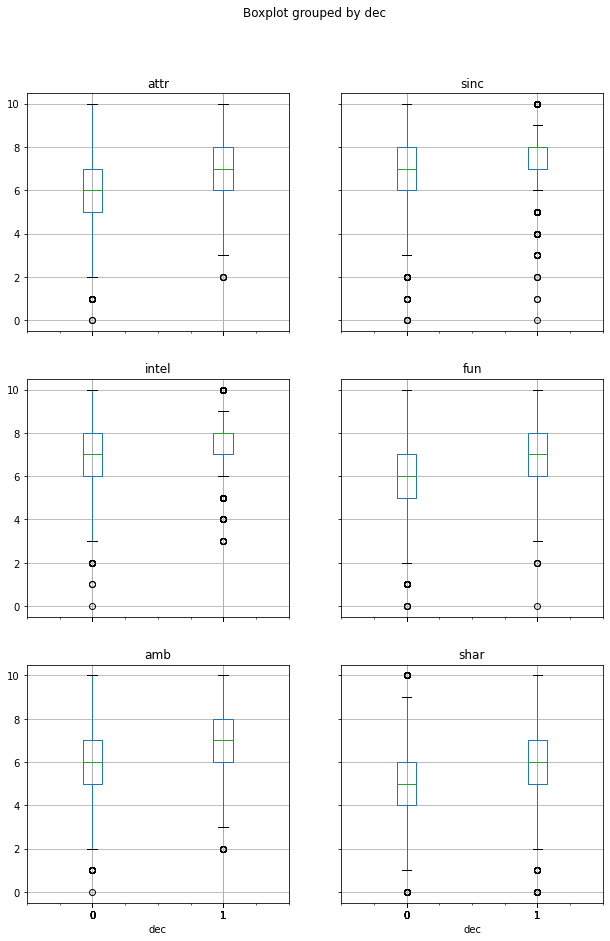

In [30]:
print("     Figure 1: Boxplot of Female Attributes Ranked by Males, Separated by Decision")
df_m.boxplot(column=['attr', 'sinc', 'intel', 'fun', 'amb', 'shar'], by='dec', figsize = (10,15));

     Figure 2: Boxplot of Male Attributes Ranked by Females, Separated by Decision


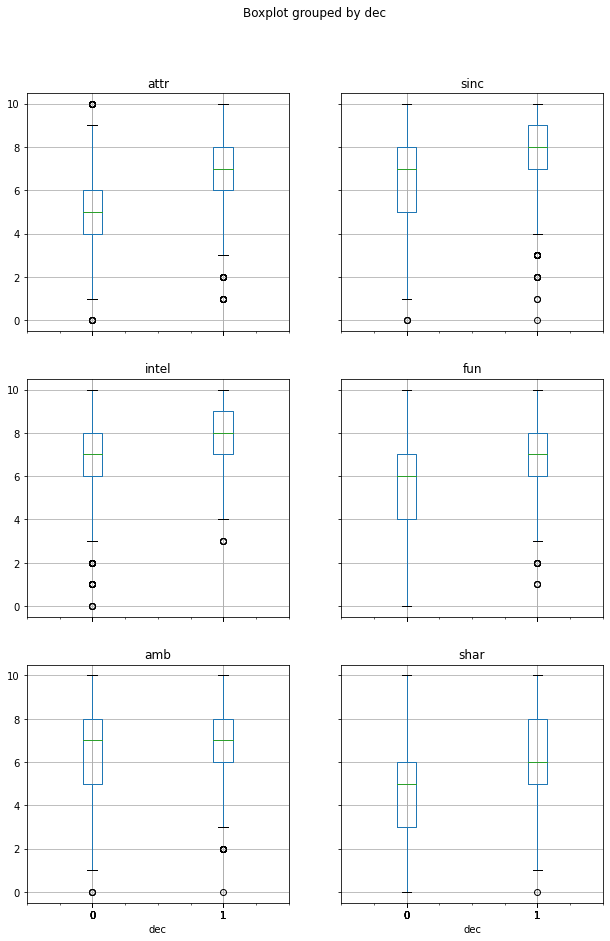

In [31]:
print("     Figure 2: Boxplot of Male Attributes Ranked by Females, Separated by Decision")
df_f.boxplot(column=['attr', 'sinc', 'intel', 'fun', 'amb', 'shar'], by='dec', figsize = (10,15));

Figures 1 and 2 show six subplots of which each represents one of the six attributes ranked in the survey. Each subplot is divided into two boxplots for the data of the partners separated by the participants' final decisions regarding the partners. 
Figure 1 shows that males look for high levels of attraction, fun, ambition, and shared interests in their partners, but they do not value sincerity or intelligence as much. On the contrary, Figure 2 shows that females value all attributes highly except for ambition.

In [32]:
# Correlation between like and attribute of partner by gender

attributes = ['attr', 'sinc', 'intel', 'fun', 'amb', 'shar']
m_corr, f_corr = [], []
for a in attributes:
    m_corr.append(df_m.like.corr(df_m[a]))    
    f_corr.append(df_f.like.corr(df_f[a]))

df_corr = pd.DataFrame({'Attributes':attributes+attributes, 'Corr':m_corr+f_corr, 'Gender':['Male','Male','Male','Male','Male','Male','Female','Female','Female','Female','Female','Female']})

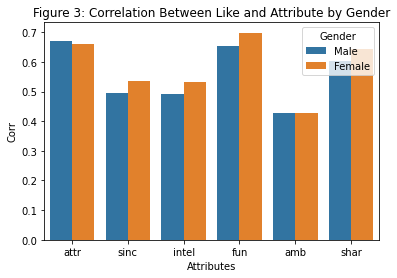

In [33]:
sns.barplot(data=df_corr, x='Attributes', y='Corr', hue='Gender').set_title('Figure 3: Correlation Between Like and Attribute by Gender');

Figure 3 is a categorical bar plot representing the correlation between participants' 'like' value given to each partner and their rankings of the same partner. It is separated by gender. It is shown that, in general, the correlation values do not vary significantly with gender. However, female rankings of sincerity, intelligence, fun, and shared interests were correlated more with how much they liked their partners. On the other hand, compared with female rankings, male rankings of attractiveness were more correlated with the degree they liked their partner. Overall, the most correlated attributes were attractiveness, fun, and shared interests while the least correlated were sincerity, intelligence, and ambition.

In [34]:
# Slopes between like and attribute of partner by gender

attributes = ['attr', 'sinc', 'intel', 'fun', 'amb', 'shar']
m_slope, f_slope = [], []
for at in attributes:
    am, b = np.polyfit(df_m.like, df_m[at], 1)
    m_slope.append(am)  
    af, b = np.polyfit(df_f.like, df_f[at], 1)
    f_slope.append(af) 

df_slope = pd.DataFrame({'Attributes':attributes+attributes, 'Slope':m_slope+f_slope, 'Gender':['Male','Male','Male','Male','Male','Male','Female','Female','Female','Female','Female','Female']})

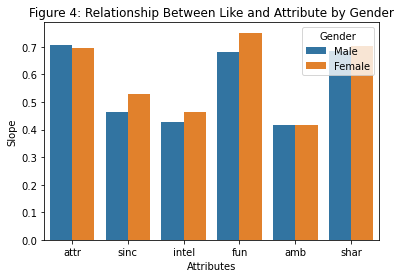

In [35]:
sns.barplot(data=df_slope, x='Attributes', y='Slope', hue='Gender').set_title('Figure 4: Relationship Between Like and Attribute by Gender');

Similar to Figure 3, Figure 4 is also a categorical bar plot separated by gender. However, Figure 4 displays the linear relationship between participants' 'like' ranking given to each partner and their rankings of the same partner's attributes. This plot follows a nearly identical trend as the previous showing that attributes with strong correlations also have closer relationships and vice versa. Thus, attractiveness, fun, and ambition contribute the most to the likability ranking of both genders while sincerity, intelligence, and ambition contribute least.

**Summary** 

Overall, the data showed that while the least desirable trait in a male partner was ambition, the least desirable traits in a female partner were sincerity and intelligence. Although there was no clear most desirable attribute for either gender, they both valued attractiveness, fun, and shared interests greatly.

### Question 2: Is it better to be someone's first speed date of the night or their last?

In [36]:
df_order = df[['order','dec']]
df_order['ratio'] = np.zeros(len(df.order))

In [37]:
r_yes_list = []
for i in range(1,23):
    total = len(df_order[df_order.order==i])
    yes = df_order.loc[(df_order.order==i) & (df_order.dec == 1)]
    n_yes = len(yes.order)
    r_yes = (n_yes/total)
    r_yes_list.append(r_yes)
    df_order.loc[(df_order.order==i) & (df_order.dec == 1),'ratio'] = r_yes * np.ones(n_yes)
    df_order.loc[(df_order.order==i) & (df_order.dec == 0),'ratio'] = (1-r_yes) * np.ones(total-n_yes)   

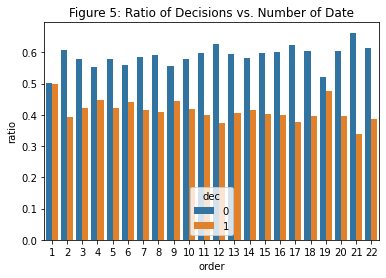

In [38]:
sns.barplot(x ='order', y='ratio', hue = 'dec', data = df_order).set_title('Figure 5: Ratio of Decisions vs. Number of Date');

Figure 5 is a categorical bar plot displaying the ratio of the participants' decisions vs. which date number of the event it was. The blue bars represent participants selecting 'no' while the orange represent 'yes.' The difference between the two bars seems significant and constant throughout the whole event except for the first date. During the first date, the difference between the ratios is the lowest with a nearly half, half split for the number of affirmative and rejection decisions. For the rest of the dates, there are far more rejective decisions to affirmative.

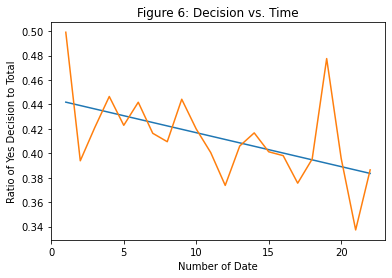

In [39]:
x_list = [i for i in range(1,23)]

#find line of best fit
a, b = np.polyfit(x_list, r_yes_list, 1)

#add line of best fit to plot
plt.plot(x_list, a*np.array(x_list)+b)


plt.plot(x_list, r_yes_list)
plt.xlabel('Number of Date')
plt.ylabel('Ratio of Yes Decision to Total')
plt.title('Figure 6: Decision vs. Time');

Figure 6 is another representation of Figure 5. It shows a lineplot of how the ratio of 'yes' decisions change with date number. Although there is high variance, there is a clear negative correlation as shown by the line of best fit. The first date yields a much higher ratio of 'yes' than the last.

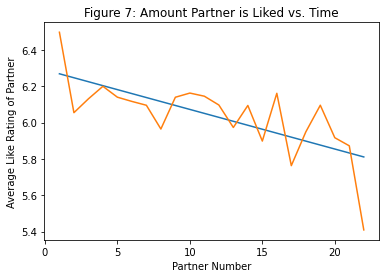

In [40]:
like = []
for i in range(1,23):
    like.append(np.mean(df[df.order == i].like))

#find line of best fit
a, b = np.polyfit(x_list, like, 1)

#add line of best fit to plot
plt.plot(x_list, a*np.array(x_list)+b)

plt.plot(x_list, like)
plt.xlabel('Partner Number')
plt.ylabel('Average Like Rating of Partner')
plt.title('Figure 7: Amount Partner is Liked vs. Time');

Figure 7 is similar to Figure 6 except that the dependent variable is the average likability rating. Just as seen in the previous figure, this plot shows a clear negative relationship showing that the first date was rated much more highly than the last.

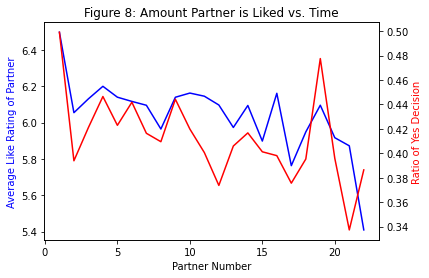

In [41]:
fig,ax = plt.subplots()
ax.plot(x_list, like, color='b')
ax.set_xlabel('Partner Number')
ax.set_ylabel('Average Like Rating of Partner', color='b')

ax2=ax.twinx()
ax2.plot(x_list, r_yes_list, color='r')
ax2.set_ylabel('Ratio of Yes Decision', color='r')

plt.title('Figure 8: Amount Partner is Liked vs. Time');

Figure 8 compares the plots from Figures 6-7, showing that they follow the same trend. The consistency between these two plots reemphasizes the negative correlation between the date number and match chances.

**Summary**

After analyzing the data through Figures 5-8, we conclude that it is better to be someone's first speed date of the night rather than their last.

### Question 3: How important do people think attractiveness is in potential mate selection vs. its real impact?

In [42]:
# using match to find the satisfied 
col = ['attr','sinc', 'intel', 'fun', 'amb', 'shar']
df_attr1_1 = df.loc[df.match==1].copy()
df_attr1_1['attr'] = df_attr1_1['attr']/df_attr1_1[col].sum(axis=1) * 100
df_attr1_1['attr_m'] = df_attr1_1.apply(lambda x:df_attr1_1.loc[df_attr1_1.iid.__eq__(x.iid) ,'attr'].sum(axis=0)/df_attr1_1.loc[df_attr1_1.iid.__eq__(x.iid)].ndim,axis = 1)
df_attr1_1['dif_attr'] = df_attr1_1['attr']-df_attr1_1['attr_m']
grp_f = df_attr1_1.groupby(by= 'gender').get_group(0)
grp_m = df_attr1_1.groupby(by= 'gender').get_group(1) 

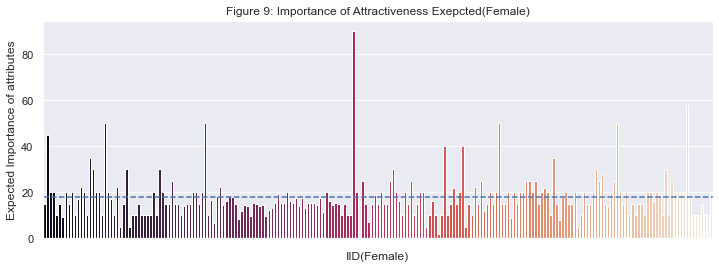

In [43]:
_ = sns.set_theme(rc = {'figure.figsize':(12,4)})
g = sns.barplot(data = grp_f,x ='iid',y='attr1_1',ci=None,palette='rocket')
_ = g.set_xticklabels('')
_ = g.set_xlabel("IID(Female)")
_ = g.set_ylabel("Expected Importance of attributes")
_ = g.set_title("Figure 9: Importance of Attractiveness Exepcted(Female)")
_=g.axhline(y = grp_f.attr1_1.mean(),ls ='--')

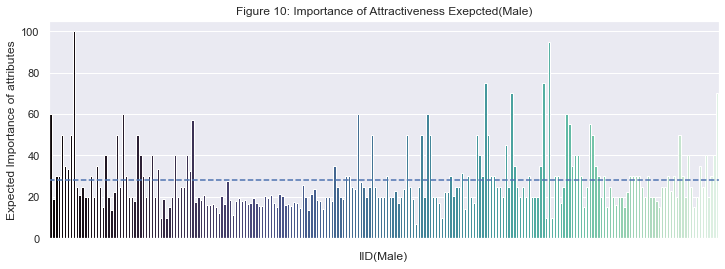

In [44]:
#sns.set_theme(rc = {'figure.figsize':(12,4)})
g = sns.barplot(data = grp_m,x ='iid',y='attr1_1',ci=None,palette='mako')
_=g.set_xticklabels('')
_ = g.set_xlabel("IID(Male)")
_ = g.set_ylabel("Expected Importance of attributes")
_ = g.set_title("Figure 10: Importance of Attractiveness Exepcted(Male)")
_=g.axhline(y = grp_m.attr1_1.mean(),ls ='--')

At the setup stage, participants were asked to state the importance of attractiveness when selecting a date. Considering gender differences, we analyze this problem of male and female seperately. 

From Figure 9 and Figure 10, we can see that compared with females, males expect to value attractiveness more.

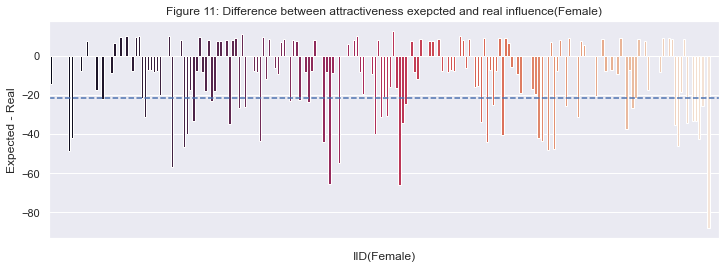

In [45]:
g = sns.barplot(data = grp_f,x ='iid',y='dif_attr',ci=None, palette='rocket')
_=g.set_xticklabels('')
g.set_xlabel("IID(Female)")
g.set_ylabel("Expected - Real")
g.set_title("Figure 11: Difference between attractiveness exepcted and real influence(Female)")
_=g.axhline(y = grp_f.dif_attr.mean(),ls ='--')

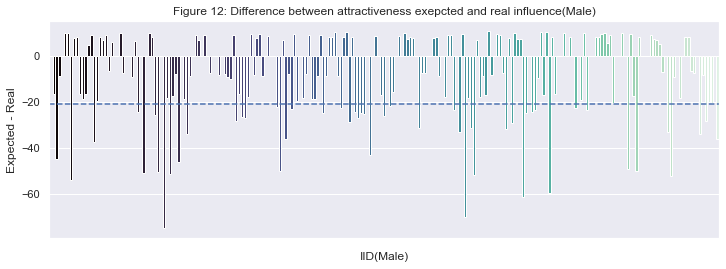

In [46]:
g = sns.barplot(data = grp_m,x ='iid',y='dif_attr',ci=None,palette='mako')
_=g.set_xticklabels('')
g.set_xlabel("IID(Male)")
g.set_ylabel("Expected - Real")
g.set_title("Figure 12: Difference between attractiveness exepcted and real influence(Male)")
_=g.axhline(y = grp_m.dif_attr.mean(),ls ='--')

Next, we further look at the real effect of attractiveness. For each participant, we use the mean value of their score on matching partner to represent the real influence. 

Figure 11 and Figure 12 represent the difference between expected and real influence. We can see that most people underestimate the influence of attractiveness regardless of their gender. 

**Summary**

Compared with females, males think attractiveness is more important. Additionally, most people underestimate the real influence of attractiveness.

### Question 4: Is being the same race important? Is dating success rate related to race?

Reference:
* Black/African American                  (1)   
* European/Caucasian-American (2)  
* Latino/Hispanic American (3)     
* Asian/Pacific Islander/Asian-American(4)  
* Native American (5)  
* Other (6)

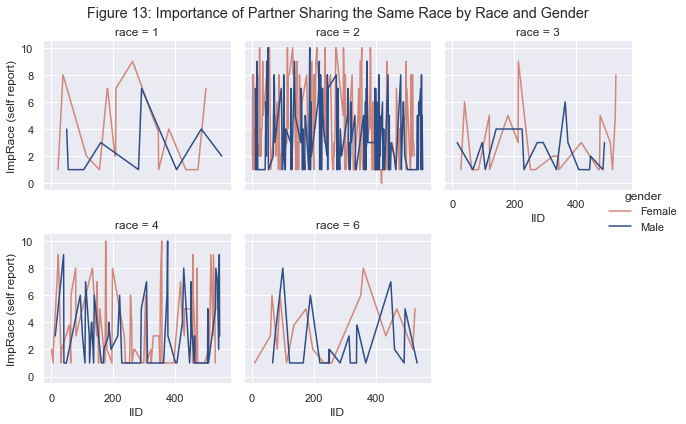

In [47]:
g = sns.FacetGrid(df.drop_duplicates('iid'), col="race",  hue="gender",col_wrap=3,palette=['#D2877A','#2F4D85'])
g.map(sns.lineplot, "iid", "imprace")
g.set_ylabels('ImpRace (self report)')
g.set_xlabels('IID')
g.add_legend()
new_labels = ['Female','Male']
for t, l in zip(g._legend.texts, new_labels):
    t.set_text(l)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Figure 13: Importance of Partner Sharing the Same Race by Race and Gender');
# personal choice, but it looks like female treat race more importance than male

First, we look at the importance each participant places on their dating partner being of the same racial/ethnic background.

Figure 13 represents the importance of their partner being of the same race for each participant grouped by race and gender. From the figure, we can briefly guess that *European/Caucasian-American (2)*  and *Asian/Pacific Islander/Asian-American(4)* prefer the same race more than participants from other backgrounds. Also, females value their partner being of the same race more than males. However, because the number of participants from different ethnic backgrounds varies, we have to look more deeply to get a more accurate conclusion.

In [48]:
data = []
for i in sorted(df.race.unique()):
    data.append([i,grp_f.drop_duplicates('iid').loc[grp_f.race == i].imprace.mean(),'Female'])
    data.append([i,grp_m.drop_duplicates('iid').loc[grp_m.race == i].imprace.mean(),'Male'])

data = pd.DataFrame(data)
data.rename(columns= {0:'Race',1:'MeanImpRace',2:'Gender'},inplace= True)


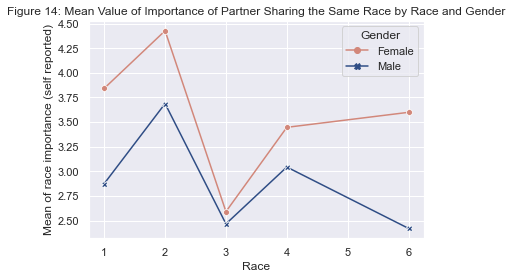

In [49]:
_ = sns.set(rc = {'figure.figsize':(6,4)})
g = sns.lineplot(data = data,x="Race", y='MeanImpRace', hue="Gender",style='Gender',markers=True, dashes=False,palette=['#D2877A','#2F4D85'])
_ = g.set_title('Figure 14: Mean Value of Importance of Partner Sharing the Same Race by Race and Gender')
_ = g.set_ylabel('Mean of race importance (self reported)');

Figure 14 represents the mean value of importance of same race for different races and genders.

From the figure, we can tell people from *European/Caucasian-American (2)* think the same race is most important when selecting a romantic partner, and people from *Latino/Hispanic American (3)* value it least. Also, compared to males, females place more importance on their partners being of the same race.

**Summary**

*European/Caucasian-American (2)* participants desire a partner of the same race more than participants from other racial backgrounds, and people from *Latino/Hispanic American (3)* value it least. Females place more importance on their partners being of the same race than males do. 

In [50]:
data = []
for i in sorted(df.race.unique()):
    n = grp_f.loc[(grp_f.race==i)].iid.unique().shape[0]
    m = grp_m.loc[(grp_m.race==i)].iid.unique().shape[0] 
    data.append([i,grp_f.loc[(grp_f.race==i)&(grp_f.sur3==1)&(grp_f.date_3==1)].iid.unique().shape[0]/n,'Female'])
    data.append([i,grp_m.loc[(grp_m.race==i)&(grp_m.sur3==1)&(grp_m.date_3==1)].iid.unique().shape[0]/m,'Male'])
data = pd.DataFrame(data)
data.rename(columns= {0:'Race',1:'RateOFsecondDate',2:'Gender'},inplace= True)


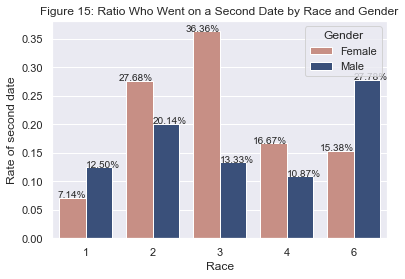

In [51]:
sns.set(rc = {'figure.figsize':(6,4)})
g = sns.barplot(data = data, x="Race", y="RateOFsecondDate", hue="Gender",palette=['#D2877A','#2F4D85'])
for _,row in data.iterrows():
    if row.Gender=='Female':
        _ = g.text(min(row.Race-1,4),row.RateOFsecondDate,'%.2f'%(row.RateOFsecondDate*100)+'%',ha = 'right',fontdict={'fontsize':10})
    else:
        _ = g.text(min(row.Race-1,4),row.RateOFsecondDate,'%.2f'%(row.RateOFsecondDate*100)+'%',ha = 'left',fontdict={'fontsize':10})
g.set_ylabel('Rate of second date');
g.set_title('Figure 15: Ratio Who Went on a Second Date by Race and Gender');

After 3-4 weeks of the speed dating experiments, researchers re-surveyed participants and asked them for updates from the speed dating event.  

We want to analyze the relationship between successful dating rate, measured by whether a date occurred after the experiment, and race. Figure 15 is the dating success rate of different genders and racial backgrounds. We can see that females from *Latino/Hispanic American (3)* had the highest dating success rate while females from *Black/African American (1)* had the lowest success rate.

**Summary**

Females from *Latino/Hispanic American (3)* had the highest dating success rate, and females from *Black/African American (1)* had the lowest success rate.  

## Prediction
We use LogisticRegression to predict whether the dating partner is matched for the participant.

In [52]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
col = list(df.columns[df.isna().sum(axis=0)!=0]) + ['satis_2','length','numdat_2']
df_pre = df.copy()
df_pre.drop(col,inplace=True,axis=1)
df_pre.drop(['iid','id','wave','partner','pid','sur2','sur3','from'],inplace=True,axis=1)
label = df_pre.match.copy()
feature = df_pre.drop(['match'],axis=1)
train_X,test_X,train_y,test_y = train_test_split(feature,label,test_size=0.4,random_state=5)

In [53]:
model=LogisticRegression(solver='lbfgs',max_iter=30)
lr=model.fit(train_X,train_y)

train_score=cross_val_score(lr,train_X,train_y,scoring='accuracy',cv=2).mean()
test_score=cross_val_score(lr,test_X,test_y,scoring='accuracy',cv=2).mean()

print('train score:',train_score,'test score:',test_score)

train score: 0.8670911261440509 test score: 0.873508353221957


## Limitations

As with any dataset, the one we have used to address our questions regarding speed dating comes with many limitations. These are important to keep in mind when interpreting our results so that we know how seriously to take our results and where to apply them. 

Firstly, our data is based on speed dating. Thus, this does not suggest any reliable compatibility. All of our analysis is based on perceived likability after a four minute speed date. 

Next, all the ratings are biased and subjective. A participant's responses may vary greatly from survey to survey independent of any change of thought. This is natural and can be better controlled with a larger sample size.

Additionally, the participants of this experiment were all students at Columbia. This is a very biased sample because they are all of similar ages, they are all students, and they all attend the same university. Thus, it is improper to generalize our findings to those of different ages, non-students, and also to anyone not attending Columbia.

Finally, this experiment only involved heterosexual relationships. Hence, these findings should only be applied to heterosexual relationships.

In summary, the sample is too specific to make too large of a generalization, so our analysis may not apply well to the average person on their journey to love.

## Conclusion

Our findings in question four were expected because European/Caucasian-Americans are a majority in America, so they can afford to have a racial preference matching their own while minorities may not be able to. Additionally, it was not surprising that women were more particular with their desires because women tend to be more fastidious when selecting a romantic partner. 

When analyzing the data to answer the first question regarding most and least desired attributes by gender, we were surprised that ambition was found to be the least valued trait by females. Our previous knowledge was that it was something women desire significantly when looking for a long-term partner. However, as the participants were all college students, they may not be at that phase of life. Additionally, as this is a speed dating experiment in which each pair only spoke for four minutes, it must have been hard to determine attributes and think deeply about anyone. It was not surprising that men valued sincerity and intelligence least for the same reasons as why women valued ambition lowly. Furthermore, it is important to note that all ratings given were subjective and biased. Hence, it is possible that a participant initially thought their partner was attractive and was therefore biased in their assessments of their partner's attributes, rating them more positively on all other measures.

Question two's results did not surprise us. It made sense to us that the first date would be more highly rated than the last for many reasons. Firstly, by the last date, the participants may be tired, causing them to be more critical of their partner. Additionally, the expectations were most likely set with the first date. Then, the participants were able to afford to be choosier over time with new options. This shows that sometimes, more options may make people pickier. This is relatable to today's online dating culture because the vast amounts of options at the swipe of a finger give us room to be pickier. However, this may result in a lack of satisfaction due to always having endless options.

The results found in question three showed that although men valued the attractiveness of their partners more than females, they both underestimated attractiveness' actual importance. Perhaps they were trying not to seem superficial in their self-assessments. Or, perhaps the importance of attractiveness was exaggerated due to the speed dating setting where participants did not have time to get to know their partners on a deeper level. Regardless, attraction matters greatly for romantic relationships. Now that contemporary culture has shifted from speed dating to online dating, perhaps attractiveness matters now more than ever. A quick glance at a picture is all some give to a potential partner before a left swipe ensues. Is this enough information to make such a judgment? Or should we be seeking deeper connections when trying to find a romantic partner? 

Overall, although the analyzed dataset is based on an experiment from nearly two decades ago, it is still relevant to learn from as human nature remains constant. 

## References

[1] Speed Dating Experiment Dataset: https://www.kaggle.com/datasets/annavictoria/speed-dating-experiment